In [154]:
import pandas as pd
import numpy as np
import numpy.ma as ma
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour
from collections import Counter
from scipy.stats import hmean



filename = 'capture20110810.binetflow'
try:
    # try to load the file from a local directory
    data = pd.read_csv(filename)
    pass
except:
    # fetch it from the url
    data = pd.read_csv('https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-42/detailed-bidirectional-flow-labels/{}'.format(filename))
    data.to_csv(filename)
    pass

In [155]:
data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/10 09:46:53.047277,3550.182373,udp,212.50.71.179,39678,<->,147.32.84.229,13363,CON,0.0,0.0,12,875,413,flow=Background-UDP-Established
1,2011/08/10 09:46:53.048843,0.000883,udp,84.13.246.132,28431,<->,147.32.84.229,13363,CON,0.0,0.0,2,135,75,flow=Background-UDP-Established
2,2011/08/10 09:46:53.049895,0.000326,tcp,217.163.21.35,80,<?>,147.32.86.194,2063,FA_A,0.0,0.0,2,120,60,flow=Background
3,2011/08/10 09:46:53.053771,0.056966,tcp,83.3.77.74,32882,<?>,147.32.85.5,21857,FA_FA,0.0,0.0,3,180,120,flow=Background
4,2011/08/10 09:46:53.053937,3427.768066,udp,74.89.223.204,21278,<->,147.32.84.229,13363,CON,0.0,0.0,42,2856,1596,flow=Background-UDP-Established


In [156]:
data['Target'] = data['Label'].str.startswith('flow=From-Botnet').astype(int)

In [157]:
targetno = data[data['Target']==0]

In [158]:
targetyes = data[data['Target']==1]

In [159]:
print('Percent Minority %f' % ((sum(data['Target'])/len(data['Target']))*100))

Percent Minority 1.450134


In [160]:
targetno.shape

(2783675, 16)

# Smote takes too long with categoricals, so I manaully resampled due to computing power restrictions

In [161]:
drop_indices = np.random.choice(targetno.index, 2740000, replace=False)
targetno_new = targetno.drop(drop_indices)

In [162]:
net_flows_new = targetno_new.append(targetyes)

In [163]:
print('Percent Minority %f' % ((sum(net_flows_new['Target'])/len(net_flows_new['Target']))*100))

Percent Minority 48.396663


In [164]:
net_flows = net_flows_new.dropna()
X = net_flows.iloc[:,0:14]
y = net_flows['Target']

In [165]:
print('Percent Minority %f' % ((sum(y_train)/len(y_train))*100))

Percent Minority 49.986949


# Actually fitting smote

In [166]:
categorics = ['StartTime', 'Proto', 'SrcAddr', 'Sport', 'Dir', 'DstAddr', 'Dport', 'State']

In [167]:
cat_index = [net_flows.columns.get_loc(c) for c in categorics if c in X]

In [168]:
sm = SMOTENC(random_state = 42, categorical_features=[0, 2, 3, 4, 5, 6, 7, 8])

In [169]:
X_res, y_res = sm.fit_resample(X, y)

In [170]:
print('Percent Minority %f' % ((sum(y_res)/len(y_res))*100))

Percent Minority 50.000000


# AAAANNNNDDD we're at a balanced dataset now

In [171]:
X.columns

Index(['StartTime', 'Dur', 'Proto', 'SrcAddr', 'Sport', 'Dir', 'DstAddr',
       'Dport', 'State', 'sTos', 'dTos', 'TotPkts', 'TotBytes', 'SrcBytes'],
      dtype='object')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression
model score: 0.640

Confusion matrix, without normalization
[[2765 5419]
 [ 441 7663]]
Normalized confusion matrix
[[0.33785435 0.66214565]
 [0.05441757 0.94558243]]


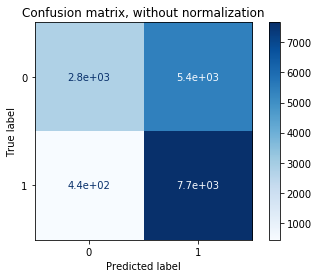

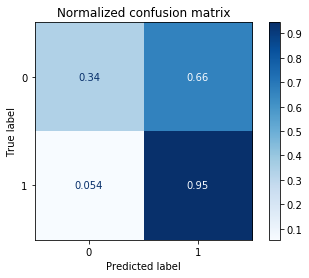

              precision    recall  f1-score   support

           0       0.86      0.34      0.49      8184
           1       0.59      0.95      0.72      8104

    accuracy                           0.64     16288
   macro avg       0.72      0.64      0.60     16288
weighted avg       0.72      0.64      0.60     16288

average precision score: 0.498
roc_auc_score: 0.554
precision-recall AUC: 0.498

RandomForestClassifier
model score: 0.855

Confusion matrix, without normalization
[[7790  394]
 [1964 6140]]
Normalized confusion matrix
[[0.95185728 0.04814272]
 [0.24234946 0.75765054]]


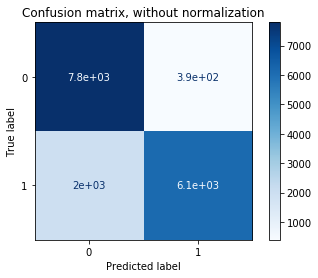

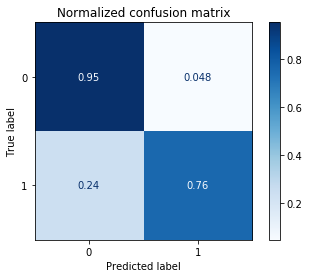

              precision    recall  f1-score   support

           0       0.80      0.95      0.87      8184
           1       0.94      0.76      0.84      8104

    accuracy                           0.86     16288
   macro avg       0.87      0.85      0.85     16288
weighted avg       0.87      0.86      0.85     16288

average precision score: 0.964
roc_auc_score: 0.964
precision-recall AUC: 0.964

GradientBoostingClassifier
model score: 0.888

Confusion matrix, without normalization
[[7423  761]
 [1066 7038]]
Normalized confusion matrix
[[0.90701369 0.09298631]
 [0.13153998 0.86846002]]


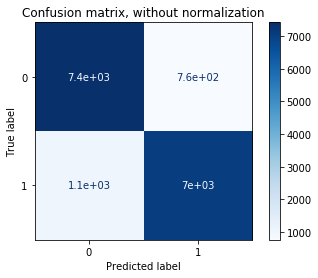

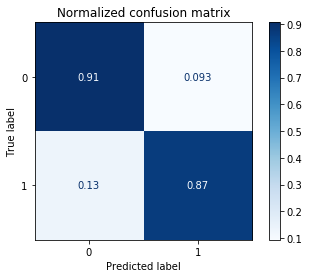

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      8184
           1       0.90      0.87      0.89      8104

    accuracy                           0.89     16288
   macro avg       0.89      0.89      0.89     16288
weighted avg       0.89      0.89      0.89     16288

average precision score: 0.952
roc_auc_score: 0.956
precision-recall AUC: 0.953



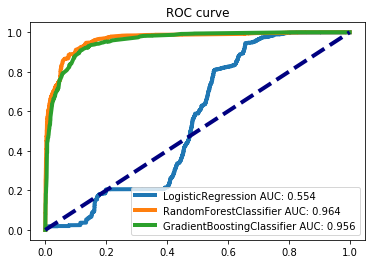

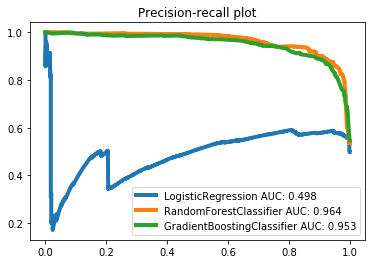

In [175]:
numeric_features = ['Dur', 'TotPkts', 'TotBytes']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])


categorical_features = ['Proto','Dir','State']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clf', None)])

roc_things = []
precision_recall_things = []

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.2, random_state=42)

classifiers = [
    LogisticRegression(),
    RandomForestClassifier(min_samples_leaf = 10),
    GradientBoostingClassifier()
]

for classifier in classifiers:
    clf.set_params(clf=classifier).fit(X_train, y_train)
    classifier_name = classifier.__class__.__name__
    print(str(classifier_name))
    print("model score: %.3f\n" % clf.score(X_test, y_test))

    
    y_score = clf.predict_proba(X_test)[:,1]
    
    y_pred = clf.predict(X_test)
    
    roc_auc = roc_auc_score(y_test, y_score)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_things.append((fpr, tpr, '{} AUC: {:.3f}'.format(classifier_name, roc_auc)))
    
    
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(clf, X_test, y_test,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()
    
    
    print(classification_report(y_test, y_pred))
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    pr_auc = auc(recall, precision)
    precision_recall_things.append((recall, precision, thresholds, '{} AUC: {:.3f}'.format(classifier_name, pr_auc)))
    
    
    print('average precision score: {:.3f}'.format(average_precision_score(y_test, y_score)))
    print('roc_auc_score: {:.3f}'.format(roc_auc))
    print('precision-recall AUC: {:.3f}'.format(pr_auc))
    print()
    
    with open('{}.pkl'.format(str(classifier_name)), 'wb') as f:
        pkl.dump(clf, f)

roc_plt = plt.figure()
lw = 4
for roc_thing in roc_things:
    fpr, tpr, label = roc_thing
    plt.plot(fpr, tpr, lw=lw, label=label)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') # dadgum no-skill line
plt.legend()
plt.title('ROC curve')

pr_plt = plt.figure()
for pr_thing in precision_recall_things:
    recall, precision, _, label = pr_thing
    plt.plot(recall, precision, lw=lw, label=label)
#ratio = y_test[y_test].shape[0] / y_test.shape[0]
#plt.hlines(y=ratio, xmin=0, xmax=1, color='navy', lw=lw, linestyle='--') # dadgum no-skill line
plt.title('Precision-recall plot')
plt.legend()   

# Threshold Stuffs

In [74]:
print(thresholds)

[1.59605787 0.59605787 0.50855059 0.46323212 0.43465323 0.37847061
 0.34574976 0.2508146  0.24589841 0.22973167 0.22614077 0.22571342
 0.22567962 0.22553195 0.21909546 0.21467432 0.21151302 0.21001691
 0.20758389 0.20568304 0.19920726 0.19773959 0.19619085 0.17812362
 0.16817913 0.16118282 0.13519806 0.12251289 0.11406282 0.10138478
 0.06943297 0.05668533 0.04547523 0.03911657 0.0324522 ]


In [75]:
precision, recall, thresholds_2 = precision_recall_curve(y_test, y_score)

a = np.column_stack((recall,precision))

a = ma.masked_less_equal(a,0)
a = ma.mask_rows(a)
f1 = hmean(a,axis=1)

In [76]:
threshold_maximizing_F1 = thresholds[np.argmax(f1)]
print('f1 optimizing threshold: {}'.format(threshold_maximizing_F1))

f1 optimizing threshold: 0.19773958590401233
